## Dataset: F1 Database from ERGAST (Regression Problem) 

## Table of Contents
#### 1. [Background](#part1)
#### 2. [Problem Statement](#part2)
#### 3. [Project Objectives](#part3)
#### 4. [Primary questions](#part4)
#### 5. [Datasets](#part5) 
#### 6. [Step 1: Load and Explore the data](#part6)  
   - [6.1 Importing Data with Pandas](#part6.1)
   - [6.2 Extracting year from unstructured date fields](#part6.2)
   - [6.3 Extracting year from unstructured text data](#part6.3)

#### 7. [Step 2: Data Wrangling on multiple tables](#part7)
   - [7.1 Merging different tables together](#part7.1)
   - [7.2 Feature Engineering using Mathematical Calculations](#part7.2) 
   - [7.3 Data Exploration and Visualization (Exploratory Data Analysis - EDA)](#part7.3)
   
#### 8. [Step 3: Data Cleansing and Transformation](#part8)
   - [8.1 Descriptive Statistics](#part8.1)
   - [8.2 Correlation](#part8.2)
   - [8.3 Univariate Analysis - Numerical variables](#part8.3)
       - [8.3.1 Identifying outliers in numerical variables](#part8.3.1)
       - [8.3.2 Rectifying outlier values in numerical variables](#part8.3.2)
       - [8.3.3 Yeo-Johnson transformation for numerical variables](#part8.3.3)       

#### 9. [Step 4: Machine Learning Modelling](#part9)
   - [9.1 Train and Test Split](#part9.1)
   - [9.2 Categorical Data Encoding](#part9.2)
   - [9.3 Missing Value Imputation](#part9.3)
   - [9.4 Variable Discretization / Binning](#part9.4)
   - [9.5 Feature Scaling: Standard Scaler](#part9.5)
   - [9.6 Linear Regression Modelling](#part9.6)
   - [9.7 Summary of linear regression model building](#part9.7)

## Background <a id="part1"></a>
Ergast.com is a webservice that provides a database of Formula 1 races, starting from the 1950 season until today. 

### Source & Acknowledgements

The dataset, downloaded from http://ergast.com/mrd/db/#csv, includes information such as the time taken in each lap, the time taken for pit stops, the performance in the qualifying rounds etc. of all Formula 1 races.

## Problem Statement <a id="part2"></a>

How to implement a linear regression model for predicting number of points achieved by a driver in F1 race

## Project Objectives <a id="part3"></a>

To extract data from a database, explore the data and formulate a prediction problem

To create a tabular data table from multiple tables based on the formulated problem

To wrangle and prepare the data ready for modeling, use the prepared data to build and evaluate a simple machine learning model

To document the process, analysis, comparison and findings

## Primary questions <a id="part4"></a>

Who (driver) is the winner for each year's Formula One Championship?

Which team (constructor) is the winner for each year's Formula One Championship?

Who (driver) has the most Championship titles till date?

Who (driver) has the most number of pole positions (grid = 1) till date?

Who (driver) has the most race wins (position = 1) till date?

How does the different grid (pole positions) affect points achievement?

How does the different rankings of fastest laps affect points achievement?

Does race age (young or old) impact on points achievement?

Does location of race impact points achievement?

## Datasets Provided <a id="part5"></a>

1. circuits;
2. constructorResults;
3. constructorStandings;
4. constructors (used here);
5. driverStandings;
6. drivers (used here);
7. lapTimes;
8. pitStops;
9. qualifying;
10. races (used here);
11. results (used here);
12. seasons;
13. status (used here).

In [1]:
# import the pacakges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# for Q-Q plots
import scipy.stats as stats

# with open-source packages
from feature_engine.transformation import (
    YeoJohnsonTransformer, 
    PowerTransformer, 
    BoxCoxTransformer, 
    LogTransformer)

# to split the datasets
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error)
from feature_engine.encoding import (
    OrdinalEncoder, 
    MeanEncoder)

from sklearn.pipeline import Pipeline
import feature_engine.imputation as mdi

from feature_engine.discretisation import (
    EqualFrequencyDiscretiser, 
    EqualWidthDiscretiser)

# the scaler 
from sklearn.preprocessing import (
    StandardScaler, 
    RobustScaler, 
    MinMaxScaler, 
    MaxAbsScaler)

# to show all the columns of the dataframe in the notebeook
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

### Step 1: Load and Explore the Data <a id="part6"></a>

### Importing Data with Pandas <a id="part6.1"></a>

In [2]:
# 1st Dataset "constructors_mod"

df_constructor = pd.read_csv('constructors.csv')
display(df_constructor.head(10))

# Drop the columns 'url', 'constructorRef', 'nationality' which are not useful

df_constructor.drop(columns = ['url', 'constructorRef', 'nationality'], axis=1, inplace=True)
df_constructor

,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso
5,6,ferrari,Ferrari,Italian,http://en.wikipedia.org/wiki/Scuderia_Ferrari
6,7,toyota,Toyota,Japanese,http://en.wikipedia.org/wiki/Toyota_Racing
7,8,super_aguri,Super Aguri,Japanese,http://en.wikipedia.org/wiki/Super_Aguri_F1
8,9,red_bull,Red Bull,Austrian,http://en.wikipedia.org/wiki/Red_Bull_Racing
9,10,force_india,Force India,Indian,http://en.wikipedia.org/wiki/Racing_Point_Forc...


,constructorId,name
0,1,McLaren
1,2,BMW Sauber
2,3,Williams
3,4,Renault
4,5,Toro Rosso
...,...,...
206,209,Manor Marussia
207,210,Haas F1 Team
208,211,Racing Point
209,213,AlphaTauri


In [3]:
# Basic summary of the dataset

print(df_constructor.shape) # 211 rows, 2 columns
print(df_constructor.size) # 422 observations in total
print(df_constructor.dtypes) # 1 categorical column and 1 numeric column

(211, 2)
422
constructorId     int64
name             object
dtype: object


In [4]:
# 2nd Dataset "results_mod"

df_result = pd.read_csv('results.csv')
df_result.head(10)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1
5,6,18,6,3,8,13,6,6,6,3.0,57,\N,\N,50,14,1:29.639,212.974,11
6,7,18,7,5,14,17,7,7,7,2.0,55,\N,\N,22,12,1:29.534,213.224,5
7,8,18,8,6,1,15,8,8,8,1.0,53,\N,\N,20,4,1:27.903,217.180,5
8,9,18,9,2,4,2,\N,R,9,0.0,47,\N,\N,15,9,1:28.753,215.100,4
9,10,18,10,7,12,18,\N,R,10,0.0,43,\N,\N,23,13,1:29.558,213.166,3


In [5]:
# Basic summary of the dataset

print(df_result.shape) # 25,399 rows, 18 columns
print(df_result.size) # 457,182 observations in total
print(df_result.dtypes) # 9 categorical columns (wrong datatype because of \N: should be int64) and 9 numeric columns

(25900, 18)
466200
resultId             int64
raceId               int64
driverId             int64
constructorId        int64
number              object
grid                 int64
position            object
positionText        object
positionOrder        int64
points             float64
laps                 int64
time                object
milliseconds        object
fastestLap          object
rank                object
fastestLapTime      object
fastestLapSpeed     object
statusId             int64
dtype: object


### Extracting year from unstructured date fields <a id="part6.2"></a>

In [6]:
# 3rd Dataset "drivers_mod"

df_driver = pd.read_csv('drivers.csv')
display(df_driver.head(10))

# Extract year in unstructured datetime data 'dob'  

df_driver['yob'] = pd.to_datetime(df_driver['dob']).dt.year

# Apply mathematical Calculations to Features such as addition of 'forename' and 'surname' with an underscore

df_driver['drivername'] = df_driver['forename'] + '_' + df_driver['surname']

# Drop the column 'url', 'forename', 'surname', 'nationality', 'dob', 'driverRef' which are no longer useful

df_driver.drop(columns = ['url', 'code', 'forename', 'surname', 'nationality', 'dob', 'driverRef'], axis=1, inplace=True)
df_driver

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen
5,6,nakajima,\N,NAK,Kazuki,Nakajima,1985-01-11,Japanese,http://en.wikipedia.org/wiki/Kazuki_Nakajima
6,7,bourdais,\N,BOU,Sébastien,Bourdais,1979-02-28,French,http://en.wikipedia.org/wiki/S%C3%A9bastien_Bo...
7,8,raikkonen,7,RAI,Kimi,Räikkönen,1979-10-17,Finnish,http://en.wikipedia.org/wiki/Kimi_R%C3%A4ikk%C...
8,9,kubica,88,KUB,Robert,Kubica,1984-12-07,Polish,http://en.wikipedia.org/wiki/Robert_Kubica
9,10,glock,\N,GLO,Timo,Glock,1982-03-18,German,http://en.wikipedia.org/wiki/Timo_Glock


,driverId,number,yob,drivername
0,1,44,1985,Lewis_Hamilton
1,2,\N,1977,Nick_Heidfeld
2,3,6,1985,Nico_Rosberg
3,4,14,1981,Fernando_Alonso
4,5,\N,1981,Heikki_Kovalainen
...,...,...,...,...
852,854,47,1999,Mick_Schumacher
853,855,24,1999,Guanyu_Zhou
854,856,21,1995,Nyck_de Vries
855,857,81,2001,Oscar_Piastri


In [7]:
# Basic summary of the dataset

print(df_driver.shape) # 854 rows, 4 columns
print(df_driver.size) # 3416 observations in total
print(df_driver.dtypes) # 2 categorical columns and 2 numeric columns

(857, 4)
3428
driverId       int64
number        object
yob            int64
drivername    object
dtype: object


### Extracting year from unstructured text data <a id="part6.3"></a>

In [8]:
# 4th Dataset "races_mod"

df_circuit = pd.read_csv('races.csv')
display(df_circuit.head(10))

# Extract year in unstructured data 'url text'

df_circuit['year'] = df_circuit['url'].str.extract('(\d+)')

df_circuit

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
5,6,2009,6,6,Monaco Grand Prix,2009-05-24,12:00:00,http://en.wikipedia.org/wiki/2009_Monaco_Grand...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
6,7,2009,7,5,Turkish Grand Prix,2009-06-07,12:00:00,http://en.wikipedia.org/wiki/2009_Turkish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
7,8,2009,8,9,British Grand Prix,2009-06-21,12:00:00,http://en.wikipedia.org/wiki/2009_British_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
8,9,2009,9,20,German Grand Prix,2009-07-12,12:00:00,http://en.wikipedia.org/wiki/2009_German_Grand...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
9,10,2009,10,11,Hungarian Grand Prix,2009-07-26,12:00:00,http://en.wikipedia.org/wiki/2009_Hungarian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,1116,2023,19,69,United States Grand Prix,2023-10-22,19:00:00,https://en.wikipedia.org/wiki/2023_United_Stat...,2023-10-20,17:30:00,2023-10-21,18:00:00,\N,\N,2023-10-20,21:00:00,2023-10-21,22:00:00
1098,1117,2023,20,32,Mexico City Grand Prix,2023-10-29,20:00:00,https://en.wikipedia.org/wiki/2023_Mexico_City...,2023-10-27,18:30:00,2023-10-27,22:00:00,2023-10-28,17:30:00,2023-10-28,21:00:00,\N,\N
1099,1118,2023,21,18,São Paulo Grand Prix,2023-11-05,17:00:00,https://en.wikipedia.org/wiki/2023_S%C3%A3o_Pa...,2023-11-03,14:30:00,2023-11-04,14:30:00,\N,\N,2023-11-03,18:00:00,2023-11-04,18:30:00
1100,1119,2023,22,80,Las Vegas Grand Prix,2023-11-19,06:00:00,https://en.wikipedia.org/wiki/2023_Las_Vegas_G...,2023-11-17,04:30:00,2023-11-17,08:00:00,2023-11-18,04:30:00,2023-11-18,08:00:00,\N,\N


In [9]:
# Display all the rows that have Null values

display(df_circuit[pd.isnull(df_circuit).any(axis=1)])

# Replace NaN value with 2021 in the year column

df_circuit['year'] = df_circuit['year'].replace(np.nan, 2021)

# Check to see if the new value 2021 is in index 1055

df_circuit.loc[1055]

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time


raceId                                                      1071
year                                                        2021
round                                                         19
circuitId                                                     18
name                                        São Paulo Grand Prix
date                                                  2021-11-14
time                                                    17:00:00
url            http://en.wikipedia.org/wiki/2021_S%C3%A3o_Pau...
fp1_date                                              2021-11-12
fp1_time                                                      \N
fp2_date                                              2021-11-13
fp2_time                                                      \N
fp3_date                                                      \N
fp3_time                                                      \N
quali_date                                            2021-11-12
quali_time               

In [10]:
# Display the row where raceID = 1035. Notice that the year is 70 in the 'year' column which should not be the case

display(df_circuit.loc[df_circuit['raceId'] == 1035])

# Replace year 70 to be year 2020 and check again

df_circuit['year'] = df_circuit['year'].replace(['70'], '2020')
df_circuit.loc[1022]

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
1022,1035,70,5,9,70th Anniversary Grand Prix,2020-08-09,13:10:00,http://en.wikipedia.org/wiki/70th_Anniversary_...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


raceId                                                      1035
year                                                        2020
round                                                          5
circuitId                                                      9
name                                 70th Anniversary Grand Prix
date                                                  2020-08-09
time                                                    13:10:00
url            http://en.wikipedia.org/wiki/70th_Anniversary_...
fp1_date                                                      \N
fp1_time                                                      \N
fp2_date                                                      \N
fp2_time                                                      \N
fp3_date                                                      \N
fp3_time                                                      \N
quali_date                                                    \N
quali_time               

In [11]:
# convert the year column datatype to integer

df_circuit['year'] = df_circuit['year'].astype(int)

# Drop the column 'url', 'time', 'date' which are no longer useful

df_circuit.drop(columns = ['url', 'time', 'date'], axis=1, inplace=True)
df_circuit

,raceId,year,round,circuitId,name,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,1116,2023,19,69,United States Grand Prix,2023-10-20,17:30:00,2023-10-21,18:00:00,\N,\N,2023-10-20,21:00:00,2023-10-21,22:00:00
1098,1117,2023,20,32,Mexico City Grand Prix,2023-10-27,18:30:00,2023-10-27,22:00:00,2023-10-28,17:30:00,2023-10-28,21:00:00,\N,\N
1099,1118,2023,21,18,São Paulo Grand Prix,2023-11-03,14:30:00,2023-11-04,14:30:00,\N,\N,2023-11-03,18:00:00,2023-11-04,18:30:00
1100,1119,2023,22,80,Las Vegas Grand Prix,2023-11-17,04:30:00,2023-11-17,08:00:00,2023-11-18,04:30:00,2023-11-18,08:00:00,\N,\N


In [12]:
# Basic summary of the dataset

print(df_circuit.shape) # 1,080 rows, 5 columns
print(df_circuit.size) # 5,400 observations in total
print(df_circuit.dtypes) # 1 categorical column and 4 numeric columns

(1102, 15)
16530
raceId          int64
year            int32
round           int64
circuitId       int64
name           object
fp1_date       object
fp1_time       object
fp2_date       object
fp2_time       object
fp3_date       object
fp3_time       object
quali_date     object
quali_time     object
sprint_date    object
sprint_time    object
dtype: object


In [13]:
# 5th Dataset "status_mod"

df_status = pd.read_csv('status.csv')
df_status.head(10)

,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine
5,6,Gearbox
6,7,Transmission
7,8,Clutch
8,9,Hydraulics
9,10,Electrical


In [14]:
# Basic summary of the dataset

print(df_status.shape) # 137 rows, 2 columns
print(df_status.size) # 274 observations in total
print(df_status.dtypes) # 1 categorical column and 1 numeric column

(139, 2)
278
statusId     int64
status      object
dtype: object


### Step 2: Data Wrangling on multiple tables <a id="part7"></a>

### Merging different tables together <a id="part7.1"></a>

In [15]:
# joining df_result with df_driver by column driverID, using inner join

df_result1 = pd.merge(df_result, df_driver, on='driverId')

# joining df_result1 with df_circuit by column raceID, using inner join

df_result2 = pd.merge(df_result1, df_circuit, on='raceId')

# joining df_result2 with df_constructor by column constructorID, using inner join

df_result3 = pd.merge(df_result2, df_constructor, on='constructorId')

# joining df_result3 with df_status by column statusID, using inner join

df_race_finished = pd.merge(df_result3, df_status, on='statusId')
df_race_finished

,resultId,raceId,driverId,constructorId,number_x,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,number_y,yob,drivername,year,round,circuitId,name_x,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,name_y,status
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1,44,1985,Lewis_Hamilton,2008,1,1,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished
1,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1,\N,1981,Heikki_Kovalainen,2008,1,1,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished
2,27,19,1,1,22,9,5,5,5,4.0,56,+46.548,5525103,53,3,1:35.462,209.033,1,44,1985,Lewis_Hamilton,2008,2,2,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished
3,25,19,5,1,23,8,3,3,3,6.0,56,+38.450,5517005,19,7,1:35.922,208.031,1,\N,1981,Heikki_Kovalainen,2008,2,2,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished
4,49,20,5,1,23,5,5,5,5,4.0,57,+26.789,5493759,49,1,1:33.193,209.062,1,\N,1981,Heikki_Kovalainen,2008,3,3,Bahrain Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25895,17224,710,346,181,36,18,13,13,13,0.0,55,\N,\N,\N,\N,\N,\N,113,\N,1936,Jo_Siffert,1964,2,39,Dutch Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Brabham-BRM,+25 Laps
25896,17103,704,346,181,28,10,13,13,13,0.0,55,\N,\N,\N,\N,\N,\N,113,\N,1936,Jo_Siffert,1965,6,39,Dutch Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Brabham-BRM,+25 Laps
25897,17820,736,347,95,11,9,13,13,13,0.0,79,\N,\N,\N,\N,\N,\N,120,\N,1930,Jo_Bonnier,1962,8,46,United States Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Porsche,+21 Laps
25898,19315,803,547,87,28,20,15,15,15,0.0,44,\N,\N,\N,\N,\N,\N,125,\N,1918,Horace_Gould,1954,5,9,British Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Cooper,+46 Laps


In [16]:
# Drop the columns 'resultId', 'raceId', 'driverId', 'constructorId', 'number_x', 'positionText', 'positionOrder', 'time', 'milliseconds', 'fastestLapTime', 'statusId', 'number_y' and 'circuitId' which are not useful

df_race_finished.drop(columns = ['resultId', 'raceId', 'driverId', 'constructorId', 'number_x', 'positionText', 'positionOrder', 'time', 'milliseconds', 'fastestLapTime', 'statusId', 'number_y', 'circuitId'], axis=1, inplace=True)
df_race_finished

,grid,position,points,laps,fastestLap,rank,fastestLapSpeed,yob,drivername,year,round,name_x,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,name_y,status
0,1,1,10.0,58,39,2,218.300,1985,Lewis_Hamilton,2008,1,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished
1,3,5,4.0,58,43,1,218.385,1981,Heikki_Kovalainen,2008,1,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished
2,9,5,4.0,56,53,3,209.033,1985,Lewis_Hamilton,2008,2,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished
3,8,3,6.0,56,19,7,208.031,1981,Heikki_Kovalainen,2008,2,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished
4,5,5,4.0,57,49,1,209.062,1981,Heikki_Kovalainen,2008,3,Bahrain Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25895,18,13,0.0,55,\N,\N,\N,1936,Jo_Siffert,1964,2,Dutch Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Brabham-BRM,+25 Laps
25896,10,13,0.0,55,\N,\N,\N,1936,Jo_Siffert,1965,6,Dutch Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Brabham-BRM,+25 Laps
25897,9,13,0.0,79,\N,\N,\N,1930,Jo_Bonnier,1962,8,United States Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Porsche,+21 Laps
25898,20,15,0.0,44,\N,\N,\N,1918,Horace_Gould,1954,5,British Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Cooper,+46 Laps


In [17]:
# rename the columns accordingly
df_race_finished.rename(columns={'name_x': 'location', 'name_y': 'constructorname'}, inplace=True)
df_race_finished

,grid,position,points,laps,fastestLap,rank,fastestLapSpeed,yob,drivername,year,round,location,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,constructorname,status
0,1,1,10.0,58,39,2,218.300,1985,Lewis_Hamilton,2008,1,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished
1,3,5,4.0,58,43,1,218.385,1981,Heikki_Kovalainen,2008,1,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished
2,9,5,4.0,56,53,3,209.033,1985,Lewis_Hamilton,2008,2,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished
3,8,3,6.0,56,19,7,208.031,1981,Heikki_Kovalainen,2008,2,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished
4,5,5,4.0,57,49,1,209.062,1981,Heikki_Kovalainen,2008,3,Bahrain Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25895,18,13,0.0,55,\N,\N,\N,1936,Jo_Siffert,1964,2,Dutch Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Brabham-BRM,+25 Laps
25896,10,13,0.0,55,\N,\N,\N,1936,Jo_Siffert,1965,6,Dutch Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Brabham-BRM,+25 Laps
25897,9,13,0.0,79,\N,\N,\N,1930,Jo_Bonnier,1962,8,United States Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Porsche,+21 Laps
25898,20,15,0.0,44,\N,\N,\N,1918,Horace_Gould,1954,5,British Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Cooper,+46 Laps


### Feature Engineer 'race_age' column using Mathematical calculations  <a id="part7.2"></a>

In [18]:
# Applying Mathematical substrations between features 'year' and 'yob' to derive the race_age of the driver

df_race_finished['race_age'] = df_race_finished['year'] - df_race_finished['yob']
df_race_finished.drop(columns = ['yob'], axis=1, inplace=True)
df_race_finished

,grid,position,points,laps,fastestLap,rank,fastestLapSpeed,drivername,year,round,location,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,constructorname,status,race_age
0,1,1,10.0,58,39,2,218.300,Lewis_Hamilton,2008,1,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,23
1,3,5,4.0,58,43,1,218.385,Heikki_Kovalainen,2008,1,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,27
2,9,5,4.0,56,53,3,209.033,Lewis_Hamilton,2008,2,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,23
3,8,3,6.0,56,19,7,208.031,Heikki_Kovalainen,2008,2,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,27
4,5,5,4.0,57,49,1,209.062,Heikki_Kovalainen,2008,3,Bahrain Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25895,18,13,0.0,55,\N,\N,\N,Jo_Siffert,1964,2,Dutch Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Brabham-BRM,+25 Laps,28
25896,10,13,0.0,55,\N,\N,\N,Jo_Siffert,1965,6,Dutch Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Brabham-BRM,+25 Laps,29
25897,9,13,0.0,79,\N,\N,\N,Jo_Bonnier,1962,8,United States Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Porsche,+21 Laps,32
25898,20,15,0.0,44,\N,\N,\N,Horace_Gould,1954,5,British Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Cooper,+46 Laps,36


In [19]:
# Basic summary of the dataset

print(df_race_finished.shape) # 25,399 rows, 14 columns
print(df_race_finished.size) # 355,586 observations in total
print(df_race_finished.dtypes) # 8 categorical columns ('position', 'fastestLap', 'rank', 'fastestLapSpeed' 
                                                # variables incorrect, should be numerical) and 6 numeric columns

(25900, 24)
621600
grid                 int64
position            object
points             float64
laps                 int64
fastestLap          object
rank                object
fastestLapSpeed     object
drivername          object
year                 int32
round                int64
location            object
fp1_date            object
fp1_time            object
fp2_date            object
fp2_time            object
fp3_date            object
fp3_time            object
quali_date          object
quali_time          object
sprint_date         object
sprint_time         object
constructorname     object
status              object
race_age             int64
dtype: object


In [20]:
# show the info of dataset

df_race_finished.info() # there are no columns with missing values 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25900 entries, 0 to 25899
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   grid             25900 non-null  int64  
 1   position         25900 non-null  object 
 2   points           25900 non-null  float64
 3   laps             25900 non-null  int64  
 4   fastestLap       25900 non-null  object 
 5   rank             25900 non-null  object 
 6   fastestLapSpeed  25900 non-null  object 
 7   drivername       25900 non-null  object 
 8   year             25900 non-null  int32  
 9   round            25900 non-null  int64  
 10  location         25900 non-null  object 
 11  fp1_date         25900 non-null  object 
 12  fp1_time         25900 non-null  object 
 13  fp2_date         25900 non-null  object 
 14  fp2_time         25900 non-null  object 
 15  fp3_date         25900 non-null  object 
 16  fp3_time         25900 non-null  object 
 17  quali_date  

### Data Exploration and Visualization (Exploratory Data Analysis - EDA)  <a id="part7.3"></a>

### Driver's Championship ranking by season

In [21]:
# Create a user-defined function championship_driver(year) that shows the total points accumulated by each driver 
# in a given season. Based on the highest total points we can derive the winner of the championship in a particular year

def championship_driver(year):
    """returns the total points for a driver in a particular season"""
    # Create a column named "total_points" to sum up the number of points obtained by each driver
    total_points = df_race_finished[(df_race_finished['year']== year)].groupby('drivername')['points'].sum().reset_index()
    
    # Sort total_points in descending order
    total_points = total_points.sort_values(by=['points'], ascending=False)
    
    # Get top 20 results based on highest number of total points
    total_points = total_points[0:20]
    
    # Show top 20 drivers
    drivers = total_points.index
    total_points.plot(kind = 'bar', x='drivername', y='points', figsize=(12,6), title = f"Driver´s championship ranking of {year}")

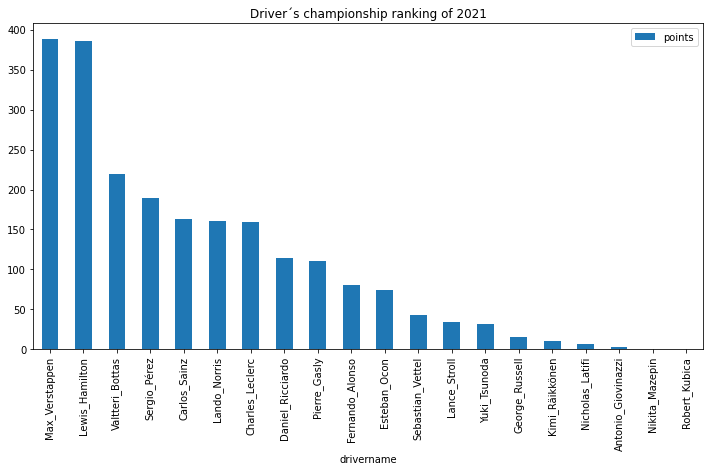

In [22]:
# choose the year to show the ranking between 2004 - 2021
championship_driver(2021) # Max Verstappen is the winner

### Constructor's Championship ranking by season

In [23]:
# Create a user-defined function championship_constructor(year) that shows the total points accumulated by each driver 
# in a given season. Based on the highest total points we can derive the winner of the championship in a particular year.

def championship_constructor(year):
    """returns the total points for a constructor in a particular season"""
    # Create a column named "total_points" to sum up the number of points obtained by each constructor
    total_points = df_race_finished[(df_race_finished['year']== year)].groupby('constructorname')['points'].sum().reset_index()
    
    # Sort total_points in descending order
    total_points = total_points.sort_values(by=['points'],ascending=False)
    
    # Get top 10 results based on highest number of total points
    total_points = total_points[0:10]
    
    # Get top 10 constructors
    drivers = total_points.index
    total_points.plot(kind = 'bar', x='constructorname', y='points', figsize=(12,6), title = f"Constructor´s championship ranking of {year}")

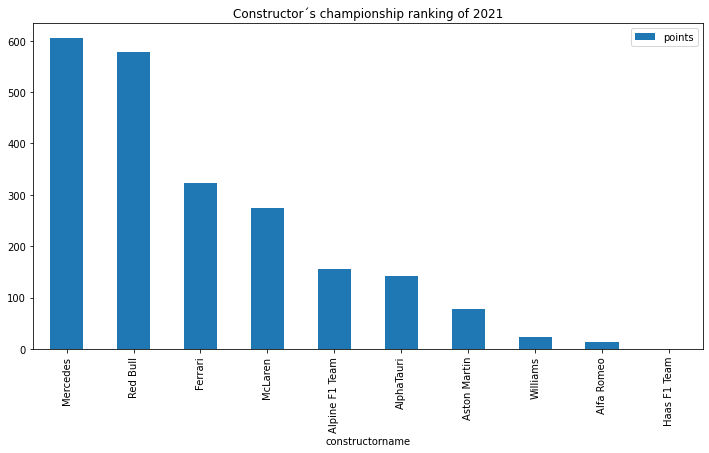

In [24]:
# choose the year to show the ranking between 2004 - 2021
championship_constructor(2021) # Mercedes is the winner

### Drivers with most Championship titles: Lewis Hamilton (7) and Michael Schumacher (7)

In [25]:
# Create a column named "sum_driver" to sum up the number of points obtained by each driver in each year

sum_driver = df_race_finished.groupby(['year','drivername'])['points'].sum().reset_index()

# Find the maximum number of points obtained by each driver and assign it to a new variable 'champions' for each year

champions = sum_driver.loc[sum_driver.reset_index().groupby(['year'])['points'].idxmax()]

# Count the frequency in which the driver obtain the maximum points for each year 

champions = champions['drivername'].value_counts().reset_index()

# Rename the columns as 'driver' and 'titles'

champions.rename(columns={'index':'drivername','count':'titles'}, inplace = True)

# Get top 20 results based on maximum points

champions = champions[0:20]

<Axes: title={'center': 'Drivers with more Championship titles'}, xlabel='drivername'>

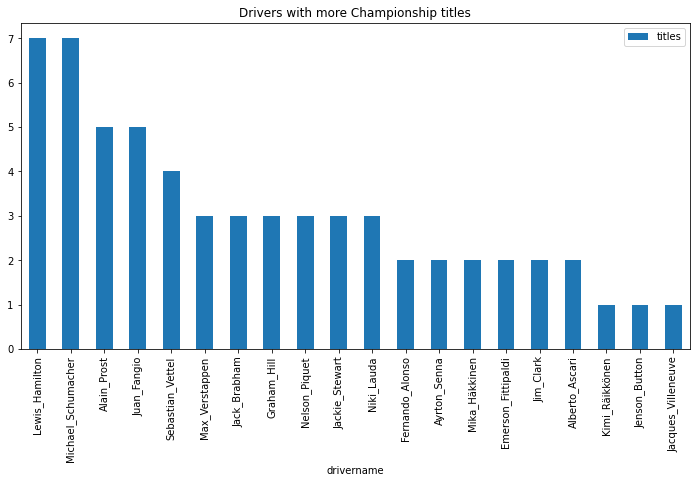

In [26]:
# Plot a bar chart to show the drivers with highest number of wins in the F1 championship over the years
champions.plot(kind = 'bar', x='drivername', y='titles', figsize=(12,6), title = f"Drivers with more Championship titles")

### Driver with most pole positions (grid = 1): Lewis Hamilton (103)

In [27]:
# Create a column named "driver_pole" to sum up the number of pole positions (grid) obtained by each driver

driver_pole = df_race_finished[df_race_finished['grid'] == 1].groupby('drivername')['grid'].sum().reset_index()

# Sort driver_pole in descending order

driver_pole = driver_pole.sort_values(by=['grid'], ascending=False)

# Get top 20 results based on total pole positions obtained by each driver

driver_pole = driver_pole[0:20]

<Axes: title={'center': 'Drivers with more pole positions (grid = 1)'}, xlabel='drivername'>

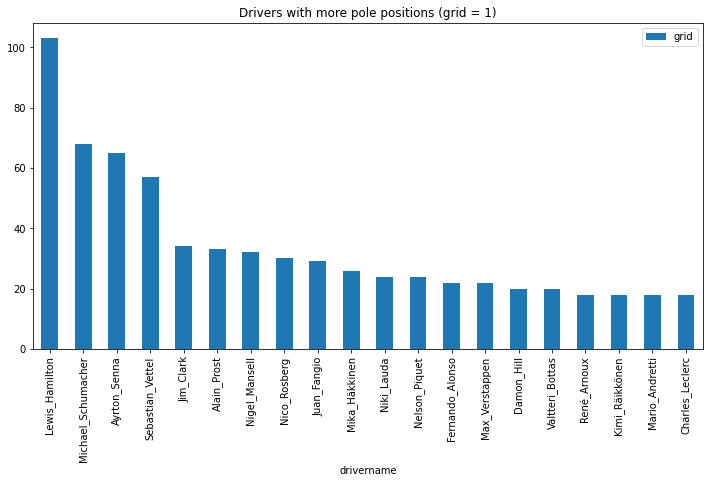

In [28]:
# Plot a bar chart to show the drivers with highest number of pole positions (grid) in the F1 championship over the years

driver_pole.plot(kind = 'bar', x='drivername', y='grid', figsize=(12,6), title = f"Drivers with more pole positions (grid = 1)")

### Driver with most numbers of fastest lap (rank = 1) : Lewis Hamilton (59)

In [29]:
# Convert the datatype of rank to integer 

df_race_finished['rank'] = pd.to_numeric(df_race_finished['rank'], errors='coerce')

# Subset the dataset by filtering for rank = 1 (fastest lap) and assign it to a new variable 'num_lap_rank'

num_lap_rank = df_race_finished[df_race_finished['rank'] == 1].groupby('drivername')['rank'].sum().reset_index()

# Sort num_lap_rank in descending order

num_lap_rank = num_lap_rank.sort_values(by=['rank'], ascending=False)

# Get top 20 results based on number of fastest lap obtained by each driver

num_lap_rank = num_lap_rank[0:20]

<Axes: title={'center': 'Drivers with most numbers of fastest lap (rank = 1)'}, xlabel='drivername'>

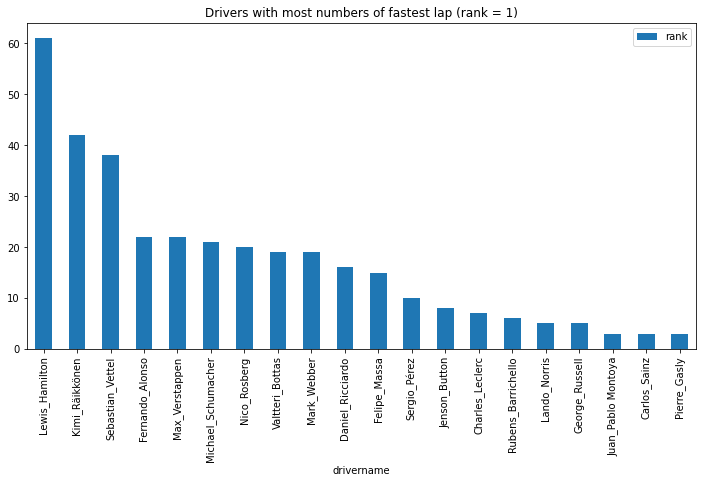

In [30]:
# Plot a bar chart to show the top 20 drivers with highest number of fastest lap in F1 championship over the years

num_lap_rank.plot(kind = 'bar', x='drivername', y='rank', figsize=(12,6), title = f"Drivers with most numbers of fastest lap (rank = 1)")

### Driver with most race wins (position = 1): Michael Schumacher (91)

In [31]:
# Subset the dataset by filtering for position = 1 (Wins) and assign it to a new variable 'num_wins'

num_wins = df_race_finished[(df_race_finished['position'] == '1')]

# Convert the datatype of position to integer 

num_wins['position'] = num_wins['position'].astype(int)

# Sum up the number of wins obtained by each driver

num_wins = num_wins.groupby('drivername')['position'].sum().reset_index()

# Sort num_wins in descending order

num_wins = num_wins.sort_values(by=['position'], ascending=False)

# Get top 20 results based on highest number of total points

num_wins = num_wins[0:20]

<Axes: title={'center': 'Drivers with more race wins (position = 1)'}, xlabel='drivername'>

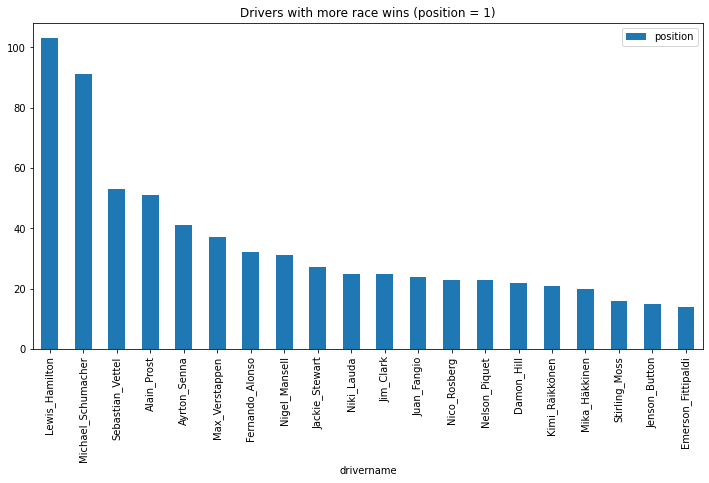

In [32]:
# Plot a bar chart to show the top 20 drivers with highest number of wins in F1 championship over the years

num_wins.plot(kind = 'bar', x='drivername', y='position', figsize=(12,6), title = f"Drivers with more race wins (position = 1)")

### Step 3: Data Cleansing and Transformation  <a id="part8"></a>

In [33]:
# Note that there are some columns with '\\N' and NaN values that have caused their datatypes to be incorrect

df_race_finished

,grid,position,points,laps,fastestLap,rank,fastestLapSpeed,drivername,year,round,location,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,constructorname,status,race_age
0,1,1,10.0,58,39,2.0,218.300,Lewis_Hamilton,2008,1,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,23
1,3,5,4.0,58,43,1.0,218.385,Heikki_Kovalainen,2008,1,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,27
2,9,5,4.0,56,53,3.0,209.033,Lewis_Hamilton,2008,2,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,23
3,8,3,6.0,56,19,7.0,208.031,Heikki_Kovalainen,2008,2,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,27
4,5,5,4.0,57,49,1.0,209.062,Heikki_Kovalainen,2008,3,Bahrain Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25895,18,13,0.0,55,\N,NaN,\N,Jo_Siffert,1964,2,Dutch Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Brabham-BRM,+25 Laps,28
25896,10,13,0.0,55,\N,NaN,\N,Jo_Siffert,1965,6,Dutch Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Brabham-BRM,+25 Laps,29
25897,9,13,0.0,79,\N,NaN,\N,Jo_Bonnier,1962,8,United States Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Porsche,+21 Laps,32
25898,20,15,0.0,44,\N,NaN,\N,Horace_Gould,1954,5,British Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Cooper,+46 Laps,36


In [34]:
# Remove all \N values in some of the columns (position, rank, fastestLap, fastestLapTime, fastestLapSpeed)

df_race_finished = df_race_finished[df_race_finished['fastestLap'] != '\\N']
df_race_finished = df_race_finished[df_race_finished['position'] != '\\N']
df_race_finished 

,grid,position,points,laps,fastestLap,rank,fastestLapSpeed,drivername,year,round,location,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,constructorname,status,race_age
0,1,1,10.0,58,39,2.0,218.300,Lewis_Hamilton,2008,1,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,23
1,3,5,4.0,58,43,1.0,218.385,Heikki_Kovalainen,2008,1,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,27
2,9,5,4.0,56,53,3.0,209.033,Lewis_Hamilton,2008,2,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,23
3,8,3,6.0,56,19,7.0,208.031,Heikki_Kovalainen,2008,2,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,27
4,5,5,4.0,57,49,1.0,209.062,Heikki_Kovalainen,2008,3,Bahrain Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25467,13,13,0.0,55,52,9.0,207.525,Antônio_Pizzonia,2005,19,Chinese Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Williams,Tyre puncture,25
25627,19,17,0.0,68,64,17.0,200.079,Vitantonio_Liuzzi,2007,7,United States Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Toro Rosso,Water pressure,27
25628,3,14,0.0,46,44,7.0,204.760,Kimi_Räikkönen,2017,8,Azerbaijan Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Ferrari,Water pressure,38
25629,4,15,0.0,60,51,3.0,166.091,Mark_Webber,2013,13,Singapore Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Red Bull,Water pressure,37


In [35]:
df_race_finished.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6272 entries, 0 to 25641
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   grid             6272 non-null   int64  
 1   position         6272 non-null   object 
 2   points           6272 non-null   float64
 3   laps             6272 non-null   int64  
 4   fastestLap       6272 non-null   object 
 5   rank             6272 non-null   float64
 6   fastestLapSpeed  6272 non-null   object 
 7   drivername       6272 non-null   object 
 8   year             6272 non-null   int32  
 9   round            6272 non-null   int64  
 10  location         6272 non-null   object 
 11  fp1_date         6272 non-null   object 
 12  fp1_time         6272 non-null   object 
 13  fp2_date         6272 non-null   object 
 14  fp2_time         6272 non-null   object 
 15  fp3_date         6272 non-null   object 
 16  fp3_time         6272 non-null   object 
 17  quali_date   

In [36]:
# convert 'position', 'points', 'fastestLap', 'rank', 'fastestLapSpeed' and 'round' variables to their correct datatypes

df_race_finished['position'] = df_race_finished['position'].astype(int)
df_race_finished['points'] = df_race_finished['points'].astype(int)
df_race_finished['fastestLap'] = df_race_finished['fastestLap'].astype(int)
df_race_finished['rank'] = df_race_finished['rank'].astype(int)
df_race_finished['fastestLapSpeed'] = df_race_finished['fastestLapSpeed'].astype(float)
df_race_finished['round'] = df_race_finished['round'].astype(int)

In [37]:
# check that the selected columns' datatypes are corrected
df_race_finished.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6272 entries, 0 to 25641
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   grid             6272 non-null   int64  
 1   position         6272 non-null   int32  
 2   points           6272 non-null   int32  
 3   laps             6272 non-null   int64  
 4   fastestLap       6272 non-null   int32  
 5   rank             6272 non-null   int32  
 6   fastestLapSpeed  6272 non-null   float64
 7   drivername       6272 non-null   object 
 8   year             6272 non-null   int32  
 9   round            6272 non-null   int32  
 10  location         6272 non-null   object 
 11  fp1_date         6272 non-null   object 
 12  fp1_time         6272 non-null   object 
 13  fp2_date         6272 non-null   object 
 14  fp2_time         6272 non-null   object 
 15  fp3_date         6272 non-null   object 
 16  fp3_time         6272 non-null   object 
 17  quali_date   

###  Descriptive statistics  <a id="part8.1"></a>

In [38]:
# Use descriptive statistics to check if there are anything amiss in each numerical column. 
# All variables seem ok at the moment (no negative values observed).

df_race_finished.describe()

,grid,position,points,laps,fastestLap,rank,fastestLapSpeed,year,round,race_age
count,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000
mean,10.640784,9.227997,4.891103,59.693240,46.399075,9.700096,204.728888,2013.507972,10.247608,28.012915
std,6.228336,5.235667,6.751939,8.713936,14.151717,5.597299,20.265229,5.397271,5.687504,4.985675
min,0.000000,1.000000,0.000000,8.000000,2.000000,1.000000,145.274000,2004.000000,1.000000,18.000000
25%,5.000000,5.000000,0.000000,53.000000,39.000000,5.000000,193.985500,2009.000000,5.000000,24.000000
50%,10.000000,9.000000,1.000000,57.000000,48.000000,9.000000,205.121500,2013.000000,10.000000,27.000000
75%,16.000000,13.000000,8.000000,68.000000,55.000000,14.000000,217.274500,2018.000000,15.000000,31.000000
max,24.000000,24.000000,50.000000,87.000000,85.000000,24.000000,257.320000,2023.000000,22.000000,43.000000


###  Correlation  <a id="part8.2"></a>

#### grid, rank (Input variables) vs. points (Target variable) are highly negatively correlated to each other. Rank and grid, as well as laps and fastestLap are positively correlated to each other. 

<Axes: title={'center': 'Correlation of features in Formula One Dataset'}>

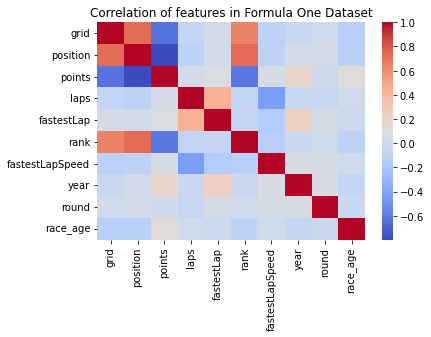

In [39]:
# Use correlation to check if there are features that are highly correlated to each other

num_cols = [n for n in df_race_finished.columns if df_race_finished[n].dtypes != "O"]

plt.title("Correlation of features in Formula One Dataset") # title name
sns.heatmap(df_race_finished[num_cols].corr(), cmap = 'coolwarm') # generate a heatmap using sns.heatmap(df_race_finished.corr(), cmap = 'coolwarm')

### Univariate analysis - numerical variables  <a id="part8.3"></a>

In [40]:
# find all numerical variables

num_cols = [c for c in df_race_finished.columns if df_race_finished[c].dtypes !='O']
df_race_finished[num_cols].head()

,grid,position,points,laps,fastestLap,rank,fastestLapSpeed,year,round,race_age
0,1,1,10,58,39,2,218.300,2008,1,23
1,3,5,4,58,43,1,218.385,2008,1,27
2,9,5,4,56,53,3,209.033,2008,2,23
3,8,3,6,56,19,7,208.031,2008,2,27
4,5,5,4,57,49,1,209.062,2008,3,27


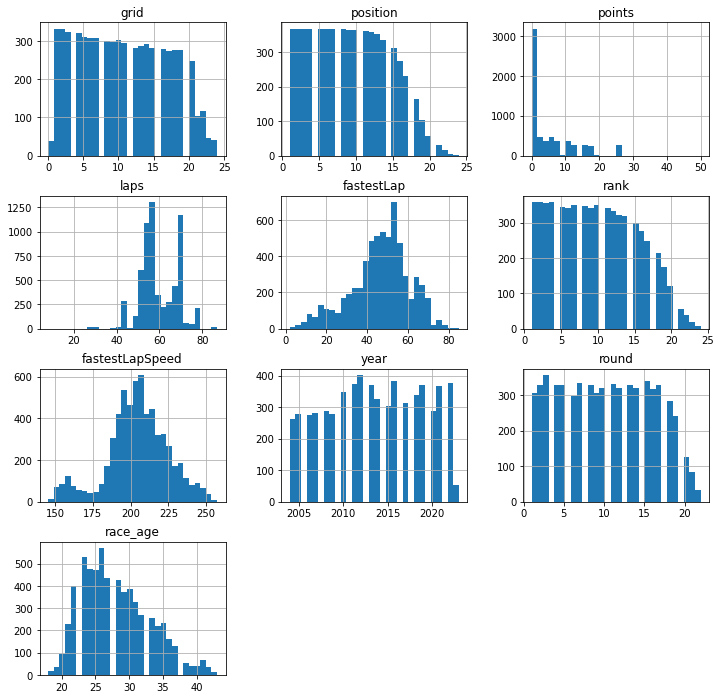

In [41]:
# plot histograms of the num variables

df_race_finished[num_cols].hist(bins=30, figsize=(12,12))
plt.show()

### Identifying outliers in numerical variables  <a id="part8.3.1"></a>
Use boxplots to reveal the presence of outliers in each variable. Among the numerical variables, all of them except 'grid', 'rank' and 'round' variables have outliers.

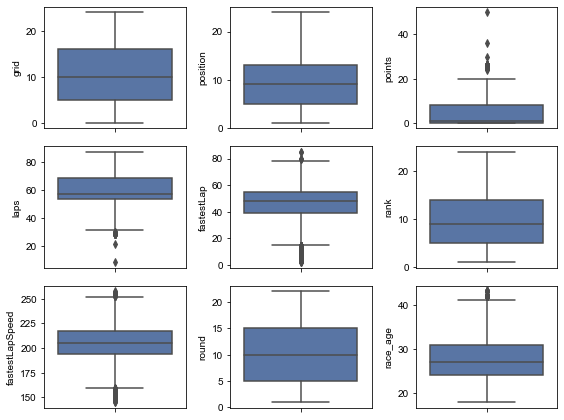

In [42]:
# Among the numerical variables, all of them except 'grid', 'rank' and 'round' variables have outliers.

fig, ax = plt.subplots(3, 3, figsize=(8, 6))
sns.set(font_scale = 1)
sns.boxplot(y= df_race_finished['grid'], ax=ax[0,0])
sns.boxplot(y= df_race_finished['position'], ax=ax[0,1])
sns.boxplot(y= df_race_finished['points'], ax=ax[0,2])
sns.boxplot(y= df_race_finished['laps'], ax=ax[1,0])
sns.boxplot(y= df_race_finished['fastestLap'], ax=ax[1,1])
sns.boxplot(y= df_race_finished['rank'], ax=ax[1,2])
sns.boxplot(y= df_race_finished['fastestLapSpeed'], ax=ax[2,0])
sns.boxplot(y= df_race_finished['round'], ax=ax[2,1])
sns.boxplot(y= df_race_finished['race_age'], ax=ax[2,2])
plt.tight_layout()

### Rectifying outlier values in numerical variables  <a id="part8.3.2"></a>
The trimming technique is more appropriate in this dataset as it merely removes extreme outliers without altering any of the outliers' true values. The points variable, being the target variable for the machine learning algorithm, will need to retain its true values for predicting outcomes. Therefore, the trimming technique is preferred. Because both 'points' and 'position' variables are positively skewed, the limits are determined using the inter-quartile range proximity rules

In [43]:
# Trimming technique used 

def find_boundaries(df, variable, distance):

    # Calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [44]:
# find limits for position variable

position_upper_limit, position_lower_limit = find_boundaries(df_race_finished, 'position', 1.5)
position_upper_limit, position_lower_limit

# Flag the outliers in the data set

outliers_position = np.where(df_race_finished['position'] > position_upper_limit, True,
                       np.where(df_race_finished['position'] < position_lower_limit, True, False))

# Trimm the dataset only of outliers in position

df_race_finished_trimmed = df_race_finished.loc[~ outliers_position ] 

df_race_finished['position'].shape, df_race_finished_trimmed.shape

((6272,), (6272, 24))

In [45]:
# find limits for points variable

points_upper_limit, points_lower_limit = find_boundaries(df_race_finished_trimmed, 'points', 1.5)
points_upper_limit, points_lower_limit

# Flag the outliers in the data set

outliers_points = np.where(df_race_finished_trimmed['points'] > points_upper_limit, True,
                       np.where(df_race_finished_trimmed['points'] < points_lower_limit, True, False))

# Trimm the dataset only of outliers in points

df_race_finished_trimmed2 = df_race_finished_trimmed.loc[~ outliers_points ] 

df_race_finished_trimmed['points'].shape, df_race_finished_trimmed2.shape

((6272,), (6008, 24))

In [46]:
# find limits for laps variable

laps_upper_limit, laps_lower_limit = find_boundaries(df_race_finished_trimmed2, 'laps', 1.5)
laps_upper_limit, laps_lower_limit

# Flag the outliers in the data set

outliers_laps = np.where(df_race_finished_trimmed2['laps'] > laps_upper_limit, True,
                       np.where(df_race_finished_trimmed2['laps'] < laps_lower_limit, True, False))

# Trimm the dataset only of outliers in laps

df_race_finished_trimmed3 = df_race_finished_trimmed2.loc[~ outliers_laps ] 

df_race_finished_trimmed2['laps'].shape, df_race_finished_trimmed3.shape

((6008,), (5985, 24))

In [47]:
# find limits for fastestLap variable

fastestLap_upper_limit, fastestLap_lower_limit = find_boundaries(df_race_finished_trimmed3, 'fastestLap', 1.5)
fastestLap_upper_limit, fastestLap_lower_limit

# Flag the outliers in the data set

outliers_fastestLap = np.where(df_race_finished_trimmed3['fastestLap'] > fastestLap_upper_limit, True,
                       np.where(df_race_finished_trimmed3['fastestLap'] < fastestLap_lower_limit, True, False))

# Trimm the dataset only of outliers in fastestLap

df_race_finished_trimmed4 = df_race_finished_trimmed3.loc[~ outliers_fastestLap ] 

df_race_finished_trimmed3['fastestLap'].shape, df_race_finished_trimmed4.shape

((5985,), (5809, 24))

In [48]:
# find limits for fastestLapSpeed variable

fastestLapSpeed_upper_limit, fastestLapSpeed_lower_limit = find_boundaries(df_race_finished_trimmed4, 'fastestLapSpeed', 1.5)
fastestLapSpeed_upper_limit, fastestLapSpeed_lower_limit

# Flag the outliers in the data set

outliers_fastestLapSpeed = np.where(df_race_finished_trimmed4['fastestLapSpeed'] > fastestLapSpeed_upper_limit, True,
                       np.where(df_race_finished_trimmed4['fastestLapSpeed'] < fastestLapSpeed_lower_limit, True, False))

# Trimm the dataset only of outliers in fastestLapSpeed

df_race_finished_trimmed5 = df_race_finished_trimmed4.loc[~ outliers_fastestLapSpeed] 

df_race_finished_trimmed4['fastestLapSpeed'].shape, df_race_finished_trimmed5.shape

((5809,), (5551, 24))

In [49]:
# find limits for race_age variable

race_age_upper_limit, race_age_lower_limit = find_boundaries(df_race_finished_trimmed5, 'race_age', 1.5)
race_age_upper_limit, race_age_lower_limit

# Flag the outliers in the data set

outliers_race_age = np.where(df_race_finished_trimmed5['race_age'] > race_age_upper_limit, True,
                       np.where(df_race_finished_trimmed5['race_age'] < race_age_lower_limit, True, False))

# Trimm the dataset only of outliers in race_age

df_race_finished_trimmed6 = df_race_finished_trimmed5.loc[~ outliers_race_age] 

df_race_finished_trimmed5['race_age'].shape, df_race_finished_trimmed6.shape

((5551,), (5504, 24))

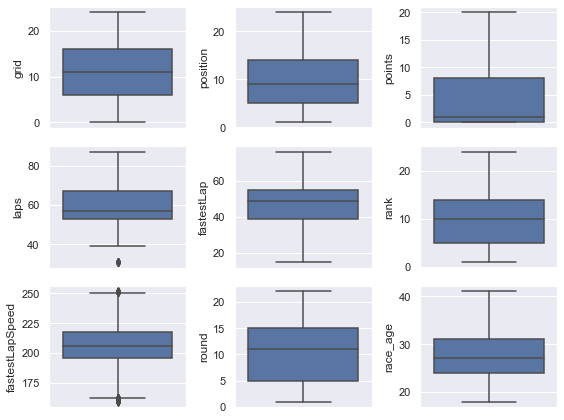

In [50]:
# After trimming of outliers, plot all the boxplots again

fig, ax = plt.subplots(3, 3, figsize=(8, 6))
sns.set(font_scale = 1)
sns.boxplot(y= df_race_finished_trimmed6['grid'], ax=ax[0,0])
sns.boxplot(y= df_race_finished_trimmed6['position'], ax=ax[0,1])
sns.boxplot(y= df_race_finished_trimmed6['points'], ax=ax[0,2])
sns.boxplot(y= df_race_finished_trimmed6['laps'], ax=ax[1,0])
sns.boxplot(y= df_race_finished_trimmed6['fastestLap'], ax=ax[1,1])
sns.boxplot(y= df_race_finished_trimmed6['rank'], ax=ax[1,2])
sns.boxplot(y= df_race_finished_trimmed6['fastestLapSpeed'], ax=ax[2,0])
sns.boxplot(y= df_race_finished_trimmed6['round'], ax=ax[2,1])
sns.boxplot(y= df_race_finished_trimmed6['race_age'], ax=ax[2,2])
plt.tight_layout()

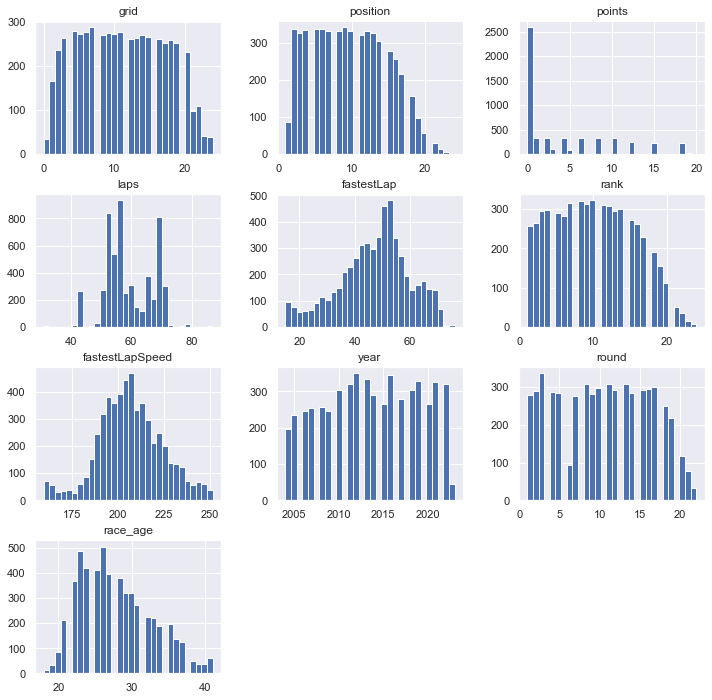

In [51]:
# After trimming of outliers, plot histograms of the num variables again

df_race_finished_trimmed6[num_cols].hist(bins=30, figsize=(12,12))
plt.show() # most of the numberical variables are not normally distributed, hence need to perform transformation on them.

### Yeo-Johnson transformation for numerical variables  <a id="part8.3.3"></a>
Since most of the distributions of numerical variables are not normally distributed, which is a requirement for most predictive model, perform Yeo-Johnson transformation on them. The Yeo-Johnson transformation is an extension of the Box-Cox transformation and can be used on variables with zero and negative values, as well as positive values. 

In [52]:
# Plot histogram and Q-Q plots for the various skewed variables: 
# 'grid', 'position', 'points', 'laps', 'fastestLap', 'rank', 'fastestLapSpeed', 'round', 'race_age'
# to have a look at the variable distribution

def diagnostic_plots(df, variable):
    
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(12,3))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()

In [53]:
# initialize the transformer with the numerical variables to transform and 

yjt = YeoJohnsonTransformer(variables = ['grid', 'position', 'points', 'laps', 'fastestLap', 'rank', 'fastestLapSpeed', 'round', 'race_age'])

# fit transformer to df_trimmed2

yjt.fit(df_race_finished_trimmed6)

# transform indicated variables in the df_trimmed2 dataset

df_race_finished_trimmed6_tf = yjt.transform(df_race_finished_trimmed6)

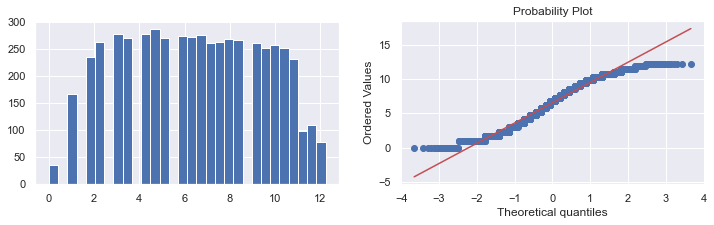

In [54]:
# plot transformed variable, most of the transformed points lie on the red line
diagnostic_plots(df_race_finished_trimmed6_tf, 'grid')

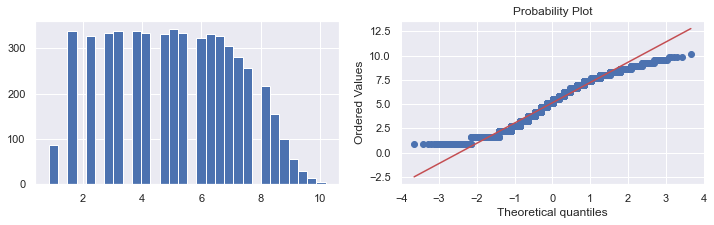

In [55]:
# plot transformed variable, most of the transformed points lie on the red line
diagnostic_plots(df_race_finished_trimmed6_tf, 'position')

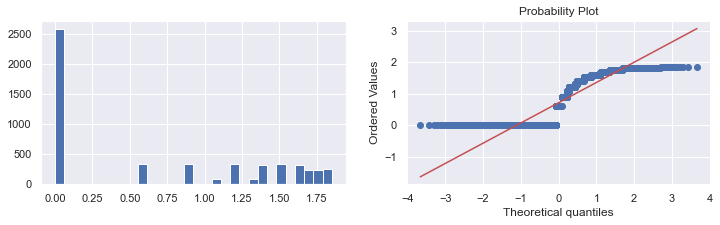

In [56]:
# plot transformed variable, most of the transformed points lie on the red line
diagnostic_plots(df_race_finished_trimmed6_tf, 'points')

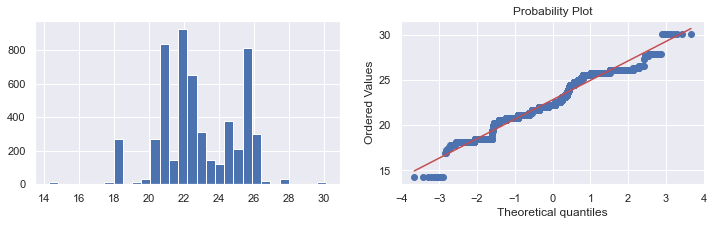

In [57]:
# plot transformed variable, most of the transformed points lie on the red line
diagnostic_plots(df_race_finished_trimmed6_tf, 'laps')

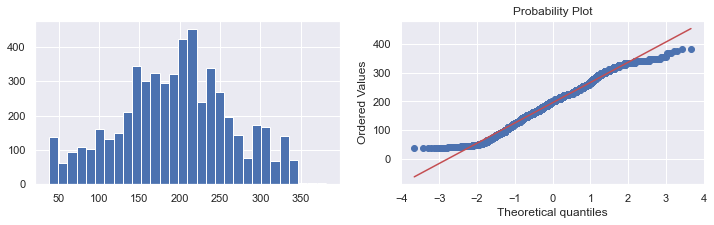

In [58]:
# plot transformed variable, most of the transformed points lie on the red line
diagnostic_plots(df_race_finished_trimmed6_tf, 'fastestLap')

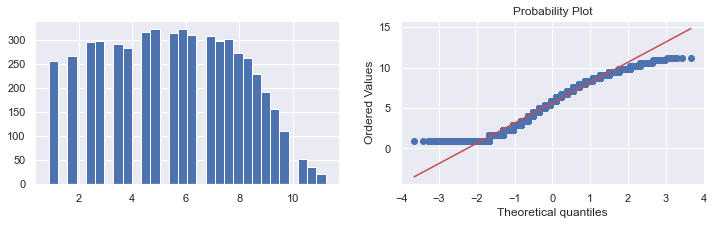

In [59]:
# plot transformed variable, most of the transformed points lie on the red line
diagnostic_plots(df_race_finished_trimmed6_tf, 'rank')

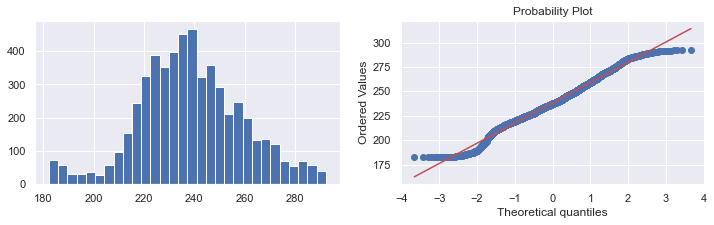

In [60]:
# plot transformed variable, most of the transformed points lie on the red line
diagnostic_plots(df_race_finished_trimmed6_tf, 'fastestLapSpeed')

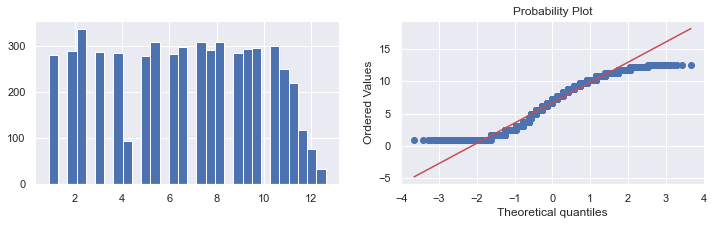

In [61]:
# plot transformed variable, most of the transformed points lie on the red line
diagnostic_plots(df_race_finished_trimmed6_tf, 'round')

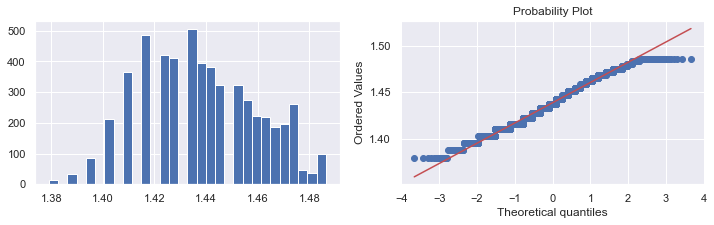

In [62]:
# plot transformed variable, most of the transformed points lie on the red line
diagnostic_plots(df_race_finished_trimmed6_tf, 'race_age')

In [63]:
# checking the transformed numerical columns 

df_race_finished_trimmed6_tf

,grid,position,points,laps,fastestLap,rank,fastestLapSpeed,drivername,year,round,location,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,constructorname,status,race_age
0,0.893055,0.864891,1.606454,22.529908,146.504000,1.616078,252.285207,Lewis_Hamilton,2008,0.908209,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,1.416195
1,2.346550,3.274392,1.221740,22.529908,168.395927,0.879767,252.386574,Heikki_Kovalainen,2008,0.908209,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,1.437937
2,5.753758,3.274392,1.221740,21.968109,227.080677,2.272381,241.241549,Lewis_Hamilton,2008,1.703374,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,1.416195
3,5.241597,2.191153,1.399336,21.968109,53.008619,4.476802,240.048388,Heikki_Kovalainen,2008,1.703374,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,1.437937
4,3.589241,3.274392,1.221740,22.249766,202.954789,0.879767,241.276085,Heikki_Kovalainen,2008,2.433008,Bahrain Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,1.437937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25467,7.668055,6.634786,-0.000000,21.684903,220.970337,5.430644,239.445925,Antônio_Pizzonia,2005,11.220352,Chinese Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Williams,Tyre puncture,1.427736
25627,10.257613,8.019033,-0.000000,25.254832,297.598893,8.735377,230.586007,Vitantonio_Liuzzi,2007,4.993000,United States Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Toro Rosso,Water pressure,1.437937
25628,2.346550,6.993691,-0.000000,19.059749,174.015236,4.476802,236.154654,Kimi_Räikkönen,2017,5.575668,Azerbaijan Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Ferrari,Water pressure,1.478373
25629,2.986506,7.343536,-0.000000,23.085781,214.912210,2.272381,190.286437,Mark_Webber,2013,8.281283,Singapore Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Red Bull,Water pressure,1.475486


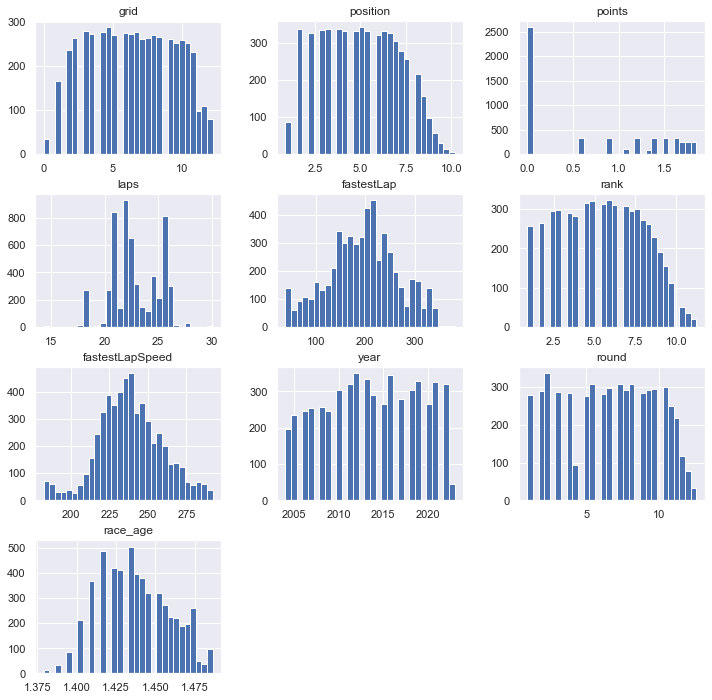

In [64]:
# After trimming of outliers and Yeo-Johnson Transformation, plot histograms of the num variables again

df_race_finished_trimmed6_tf[num_cols].hist(bins=30, figsize=(12,12))
plt.show() 

### Step 4: Machine Learning Modelling  <a id="part9"></a>

### Train and Test Split  <a id="part9.1"></a>

### Remove those columns that are not useful for modelling and separate the data set into 30% testing and 70% training sets

In [65]:
# Remove column such as 'year' that are not useful for modelling

df_race_finished_trimmed6_tf.drop(columns = ['year'], axis=1, inplace=True)
df_race_finished_trimmed6_tf

,grid,position,points,laps,fastestLap,rank,fastestLapSpeed,drivername,round,location,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,constructorname,status,race_age
0,0.893055,0.864891,1.606454,22.529908,146.504000,1.616078,252.285207,Lewis_Hamilton,0.908209,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,1.416195
1,2.346550,3.274392,1.221740,22.529908,168.395927,0.879767,252.386574,Heikki_Kovalainen,0.908209,Australian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,1.437937
2,5.753758,3.274392,1.221740,21.968109,227.080677,2.272381,241.241549,Lewis_Hamilton,1.703374,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,1.416195
3,5.241597,2.191153,1.399336,21.968109,53.008619,4.476802,240.048388,Heikki_Kovalainen,1.703374,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,1.437937
4,3.589241,3.274392,1.221740,22.249766,202.954789,0.879767,241.276085,Heikki_Kovalainen,2.433008,Bahrain Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished,1.437937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25467,7.668055,6.634786,-0.000000,21.684903,220.970337,5.430644,239.445925,Antônio_Pizzonia,11.220352,Chinese Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Williams,Tyre puncture,1.427736
25627,10.257613,8.019033,-0.000000,25.254832,297.598893,8.735377,230.586007,Vitantonio_Liuzzi,4.993000,United States Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Toro Rosso,Water pressure,1.437937
25628,2.346550,6.993691,-0.000000,19.059749,174.015236,4.476802,236.154654,Kimi_Räikkönen,5.575668,Azerbaijan Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Ferrari,Water pressure,1.478373
25629,2.986506,7.343536,-0.000000,23.085781,214.912210,2.272381,190.286437,Mark_Webber,8.281283,Singapore Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Red Bull,Water pressure,1.475486


In [66]:
# Separate the data into training (70%) and testing sets (30%)
# Target variable is Points

X_train, X_test, y_train, y_test = train_test_split(
    df_race_finished_trimmed6_tf.drop('points', axis=1), df_race_finished_trimmed6_tf['points'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((3852, 22), (1652, 22))

### Categorical Data Encoding  <a id="part9.2"></a>

In [67]:
# find all categorical variables 

cat_cols = [c for c in X_train.columns if X_train[c].dtypes=='O'] 
X_train[cat_cols].head()

,drivername,location,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,constructorname,status
2635,Carlos_Sainz,Austrian Grand Prix,2021-07-02,\N,2021-07-02,\N,2021-07-03,\N,2021-07-03,\N,\N,\N,Ferrari,Finished
8331,Ralf_Schumacher,Canadian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Toyota,+1 Lap
241,Fernando_Alonso,Malaysian Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,McLaren,Finished
4869,Marcus_Ericsson,Azerbaijan Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Sauber,Finished
21304,Christijan_Albers,Japanese Grand Prix,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,Minardi,+4 Laps


In [68]:
# check for cardinality for all categorical variables

X_train[cat_cols].nunique()

drivername         100
location            40
fp1_date            46
fp1_time            14
fp2_date            46
fp2_time            12
fp3_date            40
fp3_time            11
quali_date          46
quali_time          10
sprint_date          7
sprint_time          3
constructorname     34
status              44
dtype: int64

### Ordinal/Label encoding for Categorical variables
Since drivername, location and constructorname variables have high cardinality, Ordinal/Label encoding is more suitable to be used here for these variables

In [69]:
# create a list of categorical columns to be transformed by Ordinal encoding

ordinal_cat_cols = ['location', 'drivername', 'constructorname', 'status']

In [70]:
# pass in the list of categorical columns to be transformed by Ordinal encoding

ordinal_enc = OrdinalEncoder(
    encoding_method='arbitrary',
    variables=ordinal_cat_cols)

In [71]:
# Fit the encoder to the train set

ordinal_enc.fit(X_train, y_train)

OrdinalEncoder(encoding_method='arbitrary',
               variables=['location', 'drivername', 'constructorname',
                          'status'])

In [72]:
# Inspect which variables the encoder will encode

ordinal_enc.variables

['location', 'drivername', 'constructorname', 'status']

In [73]:
# Observe the numbers assigned to each category for all the indicated variables

ordinal_enc.encoder_dict_

{'location': {'Austrian Grand Prix': 0,
  'Canadian Grand Prix': 1,
  'Malaysian Grand Prix': 2,
  'Azerbaijan Grand Prix': 3,
  'Japanese Grand Prix': 4,
  'Mexico City Grand Prix': 5,
  'Chinese Grand Prix': 6,
  'United States Grand Prix': 7,
  'Australian Grand Prix': 8,
  'Hungarian Grand Prix': 9,
  'European Grand Prix': 10,
  'Spanish Grand Prix': 11,
  'Bahrain Grand Prix': 12,
  'Monaco Grand Prix': 13,
  'British Grand Prix': 14,
  'Singapore Grand Prix': 15,
  'Abu Dhabi Grand Prix': 16,
  'German Grand Prix': 17,
  'Saudi Arabian Grand Prix': 18,
  'Turkish Grand Prix': 19,
  'Belgian Grand Prix': 20,
  'French Grand Prix': 21,
  'Italian Grand Prix': 22,
  'San Marino Grand Prix': 23,
  'Indian Grand Prix': 24,
  'Korean Grand Prix': 25,
  'Brazilian Grand Prix': 26,
  'Mexican Grand Prix': 27,
  'Russian Grand Prix': 28,
  '70th Anniversary Grand Prix': 29,
  'Tuscan Grand Prix': 30,
  'Emilia Romagna Grand Prix': 31,
  'Dutch Grand Prix': 32,
  'Portuguese Grand Prix': 

In [74]:
# transform train and test

X_train_tf_ord_enc = ordinal_enc.transform(X_train)
X_test_tf_ord_enc = ordinal_enc.transform(X_test)

In [75]:
X_train_tf_ord_enc

,grid,position,laps,fastestLap,rank,fastestLapSpeed,drivername,round,location,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,constructorname,status,race_age
2635,6.250888,3.274392,26.047644,338.482924,1.616078,265.535707,0,6.142180,0,2021-07-02,\N,2021-07-02,\N,2021-07-03,\N,2021-07-03,\N,\N,\N,0,0,1.437937
8331,6.250888,3.762705,25.520278,174.015236,5.883049,238.873272,1,5.575668,1,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,1,1,1.451226
241,11.463015,4.224900,21.968109,174.015236,3.969925,234.080644,2,9.783744,2,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2,0,1.469330
4869,9.424043,5.885985,20.535829,179.691631,8.354636,232.417571,3,5.575668,3,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,3,0,1.437937
21304,7.668055,7.685094,19.950970,115.511129,8.354636,251.538703,4,10.747953,4,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,4,2,1.432988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17795,7.668055,6.265910,25.520278,208.906840,7.163904,260.096624,63,0.908209,0,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,9,21,1.432988
7243,4.712194,6.265910,25.784542,151.887672,7.163904,219.947147,9,10.747953,5,2021-11-05,\N,2021-11-05,\N,2021-11-06,\N,2021-11-06,\N,\N,\N,2,1,1.458994
3494,1.656587,1.571301,21.113694,141.181199,2.874959,259.586930,29,9.290987,4,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,1,0,1.469330
4778,8.119668,6.265910,22.529908,233.242700,6.748306,243.280594,38,1.703374,8,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,3,0,1.481143


In [76]:
X_train_tf_ord_enc.isnull().sum() # check for any null values

grid               0
position           0
laps               0
fastestLap         0
rank               0
fastestLapSpeed    0
drivername         0
round              0
location           0
fp1_date           0
fp1_time           0
fp2_date           0
fp2_time           0
fp3_date           0
fp3_time           0
quali_date         0
quali_time         0
sprint_date        0
sprint_time        0
constructorname    0
status             0
race_age           0
dtype: int64

In [77]:
X_test_tf_ord_enc.isnull().sum() # notice that there are 3 null values in 'drivername' and 'status' columns

grid               0
position           0
laps               0
fastestLap         0
rank               0
fastestLapSpeed    0
drivername         5
round              0
location           0
fp1_date           0
fp1_time           0
fp2_date           0
fp2_time           0
fp3_date           0
fp3_time           0
quali_date         0
quali_time         0
sprint_date        0
sprint_time        0
constructorname    0
status             3
race_age           0
dtype: int64

### Missing Value Imputation <a id="part9.3"></a>
Since most of the outliers in these variables have been removed previously, Missing Value Imputation using 'Median' was used in this dataset as this imputation will not affect the distribution of the variables 

In [78]:
# Make a list with the categorical variables

features_num_median = ['drivername', 'status']  # median imputation

In [79]:
# Instantiate each imputer within a pipeline 

pipe = Pipeline(steps=[
     ('imp_num_median', mdi.MeanMedianImputer(imputation_method = 'median', variables=features_num_median)),
])

In [80]:
# Fit the preprocessor

pipe.fit(X_train_tf_ord_enc)

Pipeline(steps=[('imp_num_median',
                 MeanMedianImputer(variables=['drivername', 'status']))])

In [81]:
# Impute the data

X_train_tf_ord_enc = pipe.transform(X_train_tf_ord_enc)
X_test_tf_ord_enc = pipe.transform(X_test_tf_ord_enc)

In [82]:
X_train_tf_ord_enc.isnull().sum() # check for any more null values

grid               0
position           0
laps               0
fastestLap         0
rank               0
fastestLapSpeed    0
drivername         0
round              0
location           0
fp1_date           0
fp1_time           0
fp2_date           0
fp2_time           0
fp3_date           0
fp3_time           0
quali_date         0
quali_time         0
sprint_date        0
sprint_time        0
constructorname    0
status             0
race_age           0
dtype: int64

In [83]:
X_test_tf_ord_enc.isnull().sum()  # check for any more null values

grid               0
position           0
laps               0
fastestLap         0
rank               0
fastestLapSpeed    0
drivername         0
round              0
location           0
fp1_date           0
fp1_time           0
fp2_date           0
fp2_time           0
fp3_date           0
fp3_time           0
quali_date         0
quali_time         0
sprint_date        0
sprint_time        0
constructorname    0
status             0
race_age           0
dtype: int64

### Variable Discretization / Binning <a id="part9.4"></a>
Variable Discretization / Binning is performed on the numerical variables to transform them from continuous into discrete variables so as to further minimise the influence of outliers. The Equal-Frequency Discretization followed by Categorical encoding is being used here so as to reorder the intervals according to the target variable, in the attempt to create a monotonic relationship between the intervals and the target.

In [84]:
# with feature engine we can automate the process for many variables
# in one line of code

disc = EqualFrequencyDiscretiser(
    q=10, variables=['grid', 'position', 'laps', 'fastestLap', 
                        'rank', 'fastestLapSpeed', 'round', 'race_age',
                    'location', 'constructorname', 'status'], return_object=True)

disc.fit(X_train_tf_ord_enc)

EqualFrequencyDiscretiser(return_object=True,
                          variables=['grid', 'position', 'laps', 'fastestLap',
                                     'rank', 'fastestLapSpeed', 'round',
                                     'race_age', 'location', 'constructorname',
                                     'status'])

In [85]:
# transform train and test

train_t = disc.transform(X_train_tf_ord_enc)
test_t = disc.transform(X_test_tf_ord_enc)

Text(0, 0.5, 'points')

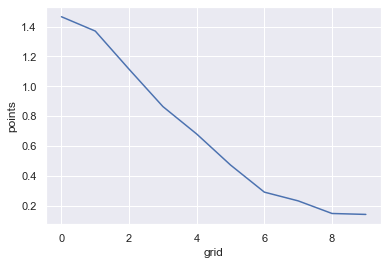

In [86]:
# Explore the relationship between bins (grid) and target (points)

pd.concat([train_t, y_train], axis=1).groupby('grid')['points'].mean().plot()
plt.ylabel('points')

In [87]:
# Order the bins

enc = OrdinalEncoder(encoding_method = 'ordered')
enc.fit(train_t, y_train)  # transformed training input and the Item_Outlet_Sales target variable

OrdinalEncoder()

In [88]:
enc.variables

In [89]:
enc.encoder_dict_

{'grid': {9: 0, 8: 1, 7: 2, 6: 3, 5: 4, 4: 5, 3: 6, 2: 7, 1: 8, 0: 9},
 'position': {6: 0, 7: 1, 8: 2, 9: 3, 5: 4, 4: 5, 3: 6, 2: 7, 1: 8, 0: 9},
 'laps': {2: 0, 6: 1, 7: 2, 0: 3, 4: 4, 1: 5, 8: 6, 3: 7, 5: 8, 9: 9},
 'fastestLap': {5: 0, 3: 1, 0: 2, 1: 3, 7: 4, 6: 5, 8: 6, 2: 7, 4: 8, 9: 9},
 'rank': {9: 0, 8: 1, 7: 2, 6: 3, 5: 4, 4: 5, 3: 6, 2: 7, 1: 8, 0: 9},
 'fastestLapSpeed': {0: 0,
  1: 1,
  4: 2,
  3: 3,
  2: 4,
  8: 5,
  5: 6,
  7: 7,
  6: 8,
  9: 9},
 'round': {5: 0, 1: 1, 8: 2, 4: 3, 6: 4, 2: 5, 7: 6, 9: 7, 3: 8, 0: 9},
 'location': {6: 0, 7: 1, 8: 2, 3: 3, 4: 4, 1: 5, 5: 6, 9: 7, 0: 8, 2: 9},
 'fp1_date': {'2022-05-27': 0,
  '2021-07-02': 1,
  '2022-05-06': 2,
  '2023-03-17': 3,
  '2022-03-18': 4,
  '2022-07-29': 5,
  '2022-05-20': 6,
  '2021-10-08': 7,
  '2022-10-21': 8,
  '2022-08-26': 9,
  '2023-03-03': 10,
  '2021-11-05': 11,
  '2022-07-01': 12,
  '2021-11-19': 13,
  '2023-03-31': 14,
  '\\N': 15,
  '2022-04-22': 16,
  '2022-07-22': 17,
  '2021-09-03': 18,
  '2022-10-28

In [90]:
# Transform the data sets

train_t = enc.transform(train_t)
test_t = enc.transform(test_t)

Text(0, 0.5, 'points')

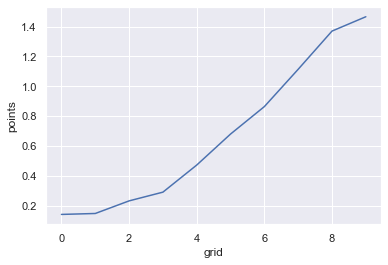

In [91]:
# Explore the monotonic relationship between bins (grid) and target (points)

pd.concat([train_t, y_train], axis=1).groupby('grid')['points'].mean().plot()
plt.ylabel('points')

Text(0, 0.5, 'points')

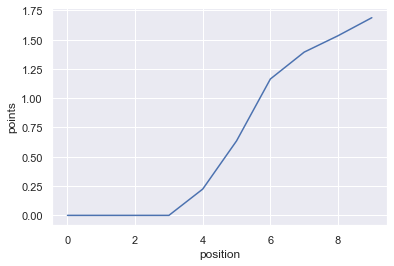

In [92]:
# Explore the monotonic relationship between between bins (position) and target (points)

pd.concat([train_t, y_train], axis=1).groupby('position')['points'].mean().plot()
plt.ylabel('points')

Text(0, 0.5, 'points')

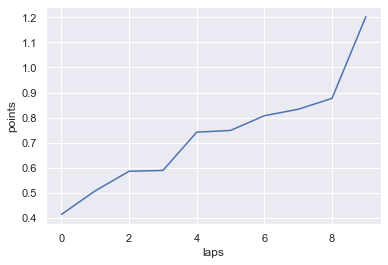

In [93]:
# Explore the monotonic relationship between bins (laps) and target (points)

pd.concat([train_t, y_train], axis=1).groupby('laps')['points'].mean().plot()
plt.ylabel('points')

Text(0, 0.5, 'points')

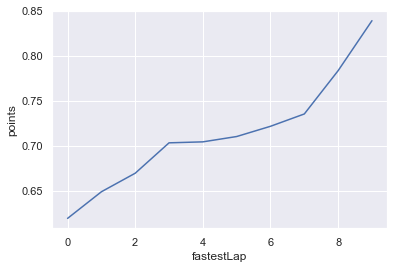

In [94]:
# Explore the monotonic relationship between bins (fastestLap) and target (points)

pd.concat([train_t, y_train], axis=1).groupby('fastestLap')['points'].mean().plot()
plt.ylabel('points')

Text(0, 0.5, 'points')

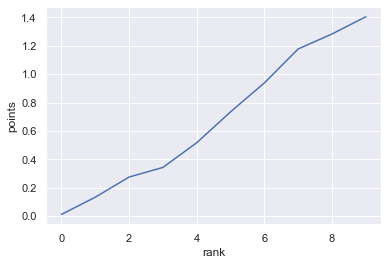

In [95]:
# Explore the monotonic relationship between bins (rank) and target (points)

pd.concat([train_t, y_train], axis=1).groupby('rank')['points'].mean().plot()
plt.ylabel('points')

Text(0, 0.5, 'points')

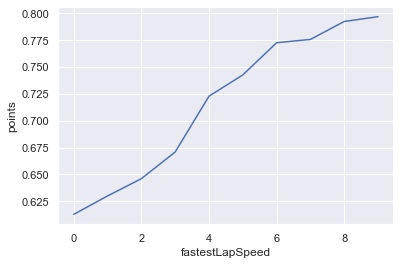

In [96]:
# Explore the monotonic relationship between bins (fastestLapSpeed) and target (points)

pd.concat([train_t, y_train], axis=1).groupby('fastestLapSpeed')['points'].mean().plot()
plt.ylabel('points')

Text(0, 0.5, 'points')

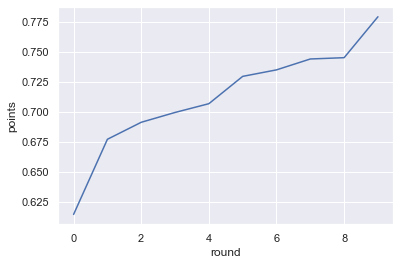

In [97]:
# Explore the monotonic relationship between bins (round) and target (points)

pd.concat([train_t, y_train], axis=1).groupby('round')['points'].mean().plot()
plt.ylabel('points')

Text(0, 0.5, 'points')

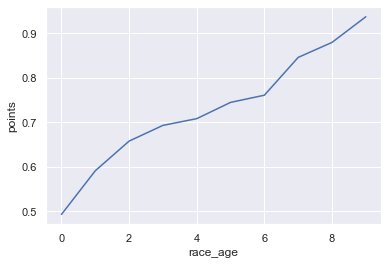

In [98]:
# Explore the monotonic relationship between bins (race_age) and target (points)

pd.concat([train_t, y_train], axis=1).groupby('race_age')['points'].mean().plot()
plt.ylabel('points')

Text(0, 0.5, 'points')

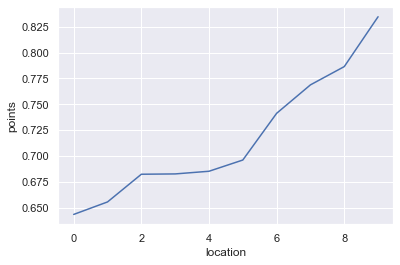

In [99]:
# Explore the monotonic relationship between bins (location) and target (points)

pd.concat([train_t, y_train], axis=1).groupby('location')['points'].mean().plot()
plt.ylabel('points')

Text(0, 0.5, 'points')

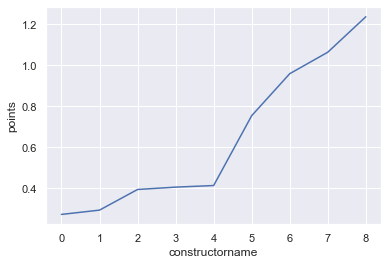

In [100]:
# Explore the monotonic relationship between bins (constructorname) and target (points)

pd.concat([train_t, y_train], axis=1).groupby('constructorname')['points'].mean().plot()
plt.ylabel('points')

Text(0, 0.5, 'points')

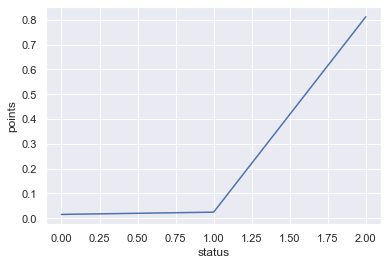

In [101]:
# Explore the monotonic relationship between bins (status) and target (points)

pd.concat([train_t, y_train], axis=1).groupby('status')['points'].mean().plot()
plt.ylabel('points')

### Feature Scaling: Standard Scaler <a id="part9.5"></a>
Standardization is the process of centering the variable at zero and standardizing the variance to 1. In order to reduce the impact of feature scale and magnitude on the performance of linear regression models, Feature Scaling using Standard Scaler can be used here to scale all the variables. To standardize features, the mean is subtracted from each observation and then divide the result by the standard deviation. The result of the preceding transformation is called the z-score and represents how many standard deviations a given observation deviates from the mean.

In [102]:
# set up the scaler

scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters

scaler.fit(train_t)

# transform train and test sets

X_train_scaled = scaler.transform(train_t)
X_test_scaled = scaler.transform(test_t)

In [103]:
# Transform the returned NumPy arrays to dataframes

X_train_scaled = pd.DataFrame(X_train_scaled, columns=train_t.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=test_t.columns)

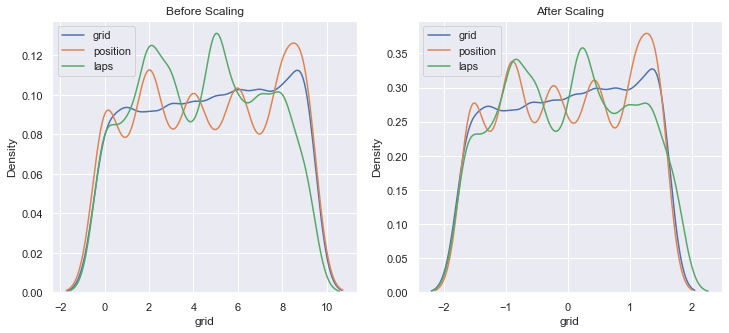

In [104]:
# Visualise the numerical variable distribution before and after scaling
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(train_t['grid'], ax=ax1, label ='grid')
sns.kdeplot(train_t['position'], ax=ax1, label ='position')
sns.kdeplot(train_t['laps'], ax=ax1, label ='laps')
ax1.legend()

# after scaling
ax2.set_title('After Scaling')
sns.kdeplot(X_train_scaled['grid'], ax=ax2, label ='grid')
sns.kdeplot(X_train_scaled['position'], ax=ax2, label ='position')
sns.kdeplot(X_train_scaled['laps'], ax=ax2, label ='laps')
ax2.legend()
plt.show()

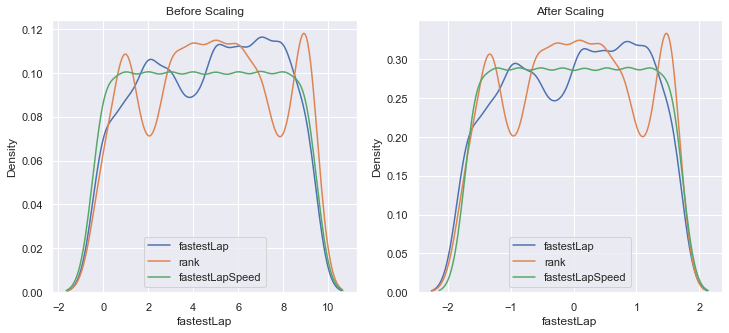

In [105]:
# Visualise the numerical variable distribution before and after scaling
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(train_t['fastestLap'], ax=ax1, label ='fastestLap')
sns.kdeplot(train_t['rank'], ax=ax1, label ='rank')
sns.kdeplot(train_t['fastestLapSpeed'], ax=ax1, label ='fastestLapSpeed')
ax1.legend()

# after scaling
ax2.set_title('After Scaling')
sns.kdeplot(X_train_scaled['fastestLap'], ax=ax2, label ='fastestLap')
sns.kdeplot(X_train_scaled['rank'], ax=ax2, label ='rank')
sns.kdeplot(X_train_scaled['fastestLapSpeed'], ax=ax2, label ='fastestLapSpeed')
ax2.legend()
plt.show()

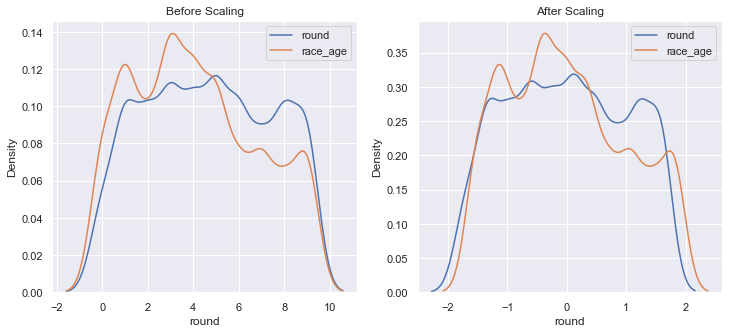

In [106]:
# Visualise the numerical variable distribution before and after scaling
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(train_t['round'], ax=ax1, label ='round')
sns.kdeplot(train_t['race_age'], ax=ax1, label ='race_age')
ax1.legend()

# after scaling
ax2.set_title('After Scaling')
sns.kdeplot(X_train_scaled['round'], ax=ax2, label ='round')
sns.kdeplot(X_train_scaled['race_age'], ax=ax2, label ='race_age')
ax2.legend()
plt.show()

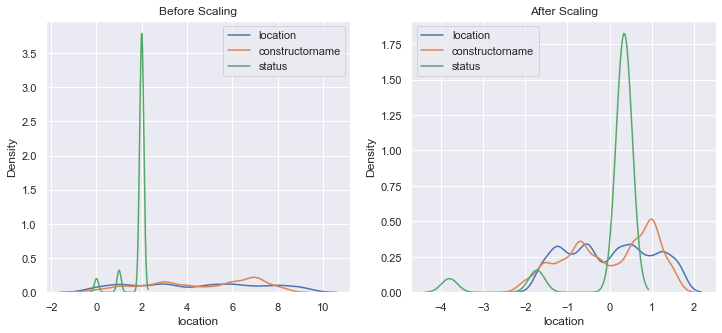

In [107]:
# Visualise the categorical variable distribution before and after scaling
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(train_t['location'], ax=ax1, label ='location')
sns.kdeplot(train_t['constructorname'], ax=ax1, label ='constructorname')
sns.kdeplot(train_t['status'], ax=ax1, label ='status')
ax1.legend()

# after scaling
ax2.set_title('After Scaling')
sns.kdeplot(X_train_scaled['location'], ax=ax2, label ='location')
sns.kdeplot(X_train_scaled['constructorname'], ax=ax2, label ='constructorname')
sns.kdeplot(X_train_scaled['status'], ax=ax2, label ='status')
ax2.legend()
plt.show()

In [108]:
# check all the transformed variables in the train_t dataset

X_train_scaled

,grid,position,laps,fastestLap,rank,fastestLapSpeed,drivername,round,location,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,constructorname,status,race_age
0,0.093034,1.097767,1.683318,1.553553,1.504819,0.173815,-1.499303,1.220337,1.258812,-2.933987,-0.061756,-2.933987,-0.074921,-3.761530,-0.064726,-2.933987,-0.125107,-0.125421,-0.096529,1.007794,0.347790,0.700573
1,0.093034,0.765016,-0.880307,-1.329398,0.088173,0.521806,-1.453852,1.220337,1.258812,-0.183843,-0.061756,-0.183843,-0.074921,-0.124694,-0.064726,-0.183843,-0.125107,-0.125421,-0.096529,1.007794,0.347790,1.436489
2,-1.624930,0.432265,0.950853,-1.329398,0.796496,-0.870158,-1.408401,0.489671,1.258812,-0.183843,-0.061756,-0.183843,-0.074921,-0.124694,-0.064726,-0.183843,-0.125107,-0.125421,-0.096529,1.007794,0.347790,0.332614
3,-0.937744,-0.233237,-0.514075,-1.329398,-1.328474,-0.522167,-1.362950,1.220337,0.189113,-0.183843,-0.061756,-0.183843,-0.074921,-0.124694,-0.064726,-0.183843,-0.125107,-0.125421,-0.096529,-0.695968,0.347790,0.700573
4,-0.250559,-0.898738,-0.514075,-0.608660,-1.328474,0.869797,-1.317499,-0.971661,0.189113,-0.183843,-0.061756,-0.183843,-0.074921,-0.124694,-0.064726,-0.183843,-0.125107,-0.125421,-0.096529,-0.695968,-1.726029,-0.771260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,-0.250559,-1.564240,-0.880307,-1.689767,-0.620151,0.173815,1.364106,1.585670,1.258812,-0.183843,-0.061756,-0.183843,-0.074921,-0.124694,-0.064726,-0.183843,-0.125107,-0.125421,-0.096529,0.581853,-3.799849,-0.771260
3848,0.780220,-1.564240,0.584621,0.832815,-0.620151,-1.218150,-1.090244,-0.971661,0.189113,-0.969598,-0.061756,-0.969598,-0.074921,-1.163790,-0.064726,-0.969598,-0.125107,-0.125421,-0.096529,1.007794,0.347790,1.804447
3849,1.467405,1.430518,0.218389,0.832815,1.150657,0.173815,-0.181226,0.489671,0.189113,-0.183843,-0.061756,-0.183843,-0.074921,-0.124694,-0.064726,-0.183843,-0.125107,-0.125421,-0.096529,1.007794,0.347790,0.332614
3850,-0.594151,-1.564240,1.317086,0.112077,-0.265989,1.217788,0.227833,1.585670,1.615378,-0.183843,-0.061756,-0.183843,-0.074921,-0.124694,-0.064726,-0.183843,-0.125107,-0.125421,-0.096529,-0.695968,0.347790,1.068531


In [109]:
# check all the transformed variables in the test_t dataset

X_test_scaled

,grid,position,laps,fastestLap,rank,fastestLapSpeed,drivername,round,location,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,constructorname,status,race_age
0,0.780220,0.432265,-0.514075,-1.329398,1.504819,-1.218150,0.818695,1.585670,-0.167453,-0.183843,-0.061756,-0.183843,-0.074921,-0.124694,-0.064726,-0.183843,-0.125107,-0.125421,-0.096529,1.433734,0.347790,0.332614
1,-0.937744,-0.898738,0.950853,1.193184,-0.620151,-0.870158,1.000499,1.585670,1.615378,-0.183843,-0.061756,-0.183843,-0.074921,-0.124694,-0.064726,-0.183843,-0.125107,-0.125421,-0.096529,-0.695968,0.347790,-0.403302
2,-0.937744,-1.564240,-1.612772,0.832815,-1.682635,-0.522167,2.000419,1.585670,1.258812,-0.183843,-0.061756,-0.183843,-0.074921,-0.124694,-0.064726,-0.183843,-0.125107,-0.125421,-0.096529,-0.270028,-1.726029,1.436489
3,1.467405,1.430518,1.683318,-0.969029,1.504819,0.521806,-0.862990,-0.606328,1.615378,-0.183843,-0.061756,-0.183843,-0.074921,-0.124694,-0.064726,-0.183843,-0.125107,-0.125421,-0.096529,1.007794,0.347790,-0.403302
4,0.436627,1.097767,0.950853,-0.248292,1.504819,-0.522167,0.000578,-1.336994,0.189113,-0.183843,-0.061756,-0.183843,-0.074921,-0.124694,-0.064726,-0.183843,-0.125107,-0.125421,-0.096529,1.007794,0.347790,0.332614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,1.123812,1.430518,0.218389,0.112077,1.504819,0.173815,0.818695,1.220337,0.545680,-0.183843,-0.061756,-0.183843,-0.074921,-0.124694,-0.064726,-0.183843,-0.125107,-0.125421,-0.096529,1.433734,0.347790,1.068531
1648,-0.937744,-1.564240,-1.246539,-0.608660,-0.620151,-1.566141,1.091401,0.124338,-0.524019,-0.183843,-0.061756,-0.183843,-0.074921,-0.124694,-0.064726,-0.183843,-0.125107,-0.125421,-0.096529,0.581853,0.347790,-0.403302
1649,0.780220,-1.564240,-1.612772,0.832815,-0.265989,-1.566141,0.000578,-0.971661,-0.880585,-0.183843,-0.061756,-0.183843,-0.074921,-0.124694,-0.064726,-0.183843,-0.125107,-0.125421,-0.096529,1.007794,0.347790,1.436489
1650,0.780220,0.765016,0.218389,-1.689767,1.504819,1.565779,0.727793,-1.702326,-1.237151,-0.183843,-0.061756,-0.183843,-0.074921,-0.124694,-0.064726,-0.183843,-0.125107,-0.125421,-0.096529,0.581853,0.347790,-0.035344


### Linear Regression Modelling <a id="part9.6"></a>
Once all the variables have been transformed and scaled, the linear regression model can be built. To evaluate the model, the Mean Absolute Error (MAE), Mean Squared Error (MSE) and R-squared values can be used. The lower the MAE and MSE scores, the better the model performance. The higher the R-squared value, the better the model performance.

In [110]:
# Build Linear Regression Model
lm_reg = linear_model.LinearRegression()
lm_reg.fit(X_train_scaled, y_train)

# Evaluate the Linear Regression Model using Mean Absolute Error (MAE)
# The lower MAE, the better model performance, note that the test_mae (0.20665) are similar to train_mae (0.20793), 
# confirming that the trained dataset is not overfitting
print('train_mae:', mean_absolute_error(lm_reg.predict(X_train_scaled), y_train), 
      '\n test_mae:', mean_absolute_error(lm_reg.predict(X_test_scaled), y_test))

# Evaluate the Linear Regression Model using Mean Squared Error (MSE)
# The lower MSE, the better model performance, note that the test_mse (0.06966) are similar to train_mse (0.07118), 
# confirming that the trained dataset is not overfitting
print('train_mse:', mean_squared_error(lm_reg.predict(X_train_scaled), y_train), 
      '\n test_mse:', mean_squared_error(lm_reg.predict(X_test_scaled), y_test))

# R-squared value of the model
# The higher the R-squared value, the better model performance
print('train_r2:', lm_reg.score(X_train_scaled, y_train))
print('test_r2:', lm_reg.score(X_test_scaled, y_test))

train_mae: 0.20793521038452914 
 test_mae: 0.2066510922984163
train_mse: 0.07117977068506064 
 test_mse: 0.0696592995223241
train_r2: 0.8642486170860012
test_r2: 0.8682119758370929


## Summary of linear regression model building <a id="part9.7"></a>
1. Based on several trials of optimizing the model, it is observed that the initial transformation of numerical variables using different techniques (Square-Root, Cube-Root Power transformation, Box-Cox, Log and Yeo-Johnson transformation) has a significant impact on the MAE/MSE/R-squared value of the model, of which Yeo-Johnson transformation did the best. This means that the closer the numerical variables are transformed towards a normal distribution, the better the predictive capability of the model.
2. Discretization/binning of the numerical variables using EqualFrequencyDiscretizer performs better than EqualWidthDiscretizer with categorical encoding.
3. However, there is not much difference in performance between using different Feature Scalers.

## End of Notebook